In [2]:
#import cv2
import numpy as np
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn import preprocessing 
import os
import glob
import pandas as pd
import gc

Load Data

In [3]:
mergedgdiavg_new_df = pd.read_csv('./data/test/labels/merged_gdiavg.csv', parse_dates = ["Event_Date"])

FileNotFoundError: File b'./data/test/labels/merged_gdiavg.csv' does not exist

In [3]:
d_mergedgdiavg_new_df = mergedgdiavg_new_df[True != mergedgdiavg_new_df['GDI'].isnull()]

In [5]:
images = []
labels = []
for root, dirs, files in os.walk('./data/densepose-out'):
    if(root.endswith('processed')):
        image_dir_name = (root[root.rfind('\\')+1:])
        if(d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False).any()):
            dirImages = []
            img_cnt = 0
            for file in files:
                if(file.endswith('_IUV.png')):
                    image_file_path = os.path.join(root, file)
                    iuv = cv2.imread(image_file_path)
                    flatten_iuv = iuv.flatten()
                    del iuv
                    if(not all(flatten_iuv==0)):
                        dirImages.append(flatten_iuv)
                        del flatten_iuv
                        img_cnt+=1
                    if(img_cnt>5):
                        break;
            images.append(np.concatenate(np.array(dirImages)))
            labels.append(d_mergedgdiavg_new_df.GDI[d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False)].values[0])
print(len(images))
#print(np.array(images).shape)

435


In [6]:
#images = []
#labels = []
#for root, dirs, files in os.walk('./data/densepose-out'):
    if(root.endswith('processed')):
        image_dir_name = (root[root.rfind('\\')+1:])
        if(d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False).any()):
            gdiscore = d_mergedgdiavg_new_df.GDI[d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False)].values[0]
            dirImages = []
            img_cnt = 0
            for file in files:
                if(file.endswith('_IUV.png')):
                    image_file_path = os.path.join(root, file)
                    iuv = cv2.imread(image_file_path)
                    flatten_iuv = iuv.flatten()
                    del iuv
                    if(not all(flatten_iuv==0)):
                        images.append(flatten_iuv)
                        labels.append(gdiscore)
                        del flatten_iuv
                        img_cnt+=1
                    if(img_cnt>100):
                        break;
            #images.append(np.concatenate(np.array(dirImages)))
            #labels.append(d_mergedgdiavg_new_df.GDI[d_mergedgdiavg_new_df['Video_File'].str.contains(image_dir_name, na=False)].values[0])
print(len(images))
#print(np.array(images).shape)

43935


In [6]:
train_split = 0.8 # ratio of training examples to put into train

In [7]:
#del mergedgdiavg_new_df
del d_mergedgdiavg_new_df
gc.collect()

27

In [8]:
X = np.array(images)
X.shape

(435, 5529600)

In [9]:
del images
gc.collect()

0

In [10]:
Y=np.array(labels)

In [11]:
del labels
gc.collect()

0

In [12]:
X_normalized = preprocessing.scale(X)

E:\MY\Anaconda3\envs\cs229finalproject\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [14]:
del X
gc.collect()

NameError: name 'X' is not defined

In [15]:
train_dev_split = np.random.rand(len(Y)) < train_split # split data into 90% train, 10% dev, based on lenghto of labels
X_train = X_normalized[train_dev_split]
X_test = X_normalized[~train_dev_split]
Y_train = Y[train_dev_split]
Y_test = Y[~train_dev_split]

In [17]:
#del X
del Y
del X_normalized
gc.collect()

0

In [18]:
# Create linear regression object using scitkit
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [ 2.28266931e-04 -6.93468231e-05  9.69523348e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [19]:
print("Root mean squared error of Linear Regression: %.2f"
      % sqrt(mean_squared_error(Y_test, Y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))

Root mean squared error of Linear Regression: 13.00
Variance score: 0.10


In [20]:
Y_pred_0rule = np.full_like(Y_test, np.mean(Y_train))  

# The mean squared error
print("Root mean squared error of Zero Rule: %.2f"
      % sqrt(mean_squared_error(Y_test, Y_pred_0rule)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, Y_pred_0rule))

Root mean squared error of Zero Rule: 13.74
Variance score: -0.00


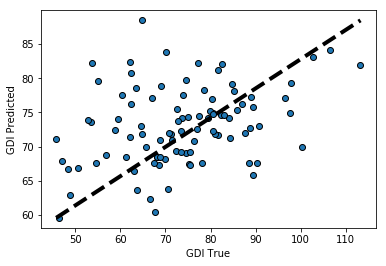

In [21]:
# Plot predicted vs. true
fig, ax = plt.subplots()
ax.scatter(Y_test, Y_pred, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_pred.min(), Y_pred.max()], 'k--', lw=4)
ax.set_xlabel('GDI True')
ax.set_ylabel('GDI Predicted')
plt.show()